In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Necessary imports

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import sys

## Loading text file to train

In [ ]:
# load ascii text and covert to lowercase
filename = "data.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

## preparing the data

In [ ]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [ ]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  35215
Total Vocab:  61


## Finding patters in the data

In [ ]:
...
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  35115


## Data normalization with one hot encoding

In [ ]:
...
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = to_categorical(dataY)

## Building the LSTM model

In [ ]:
...
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'],)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          264192    
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 61)                15677     
                                                                 
Total params: 805,181
Trainable params: 805,181
Non-trainable params: 0
_________________________________________________________________


## Defining early stopping monitoring validation loss

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=4,
    restore_best_weights=True)

## Defining the checkpoints and the callback function

In [ ]:
...
# define the checkpoint
filepath="/content/drive/MyDrive/RNN-lstm/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
# define the callback function
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, early_stopping]

## Training the model

In [ ]:
history = model.fit(X, y, epochs=100, batch_size=128, validation_split=0.1, callbacks=callbacks_list)

Epoch 1/100
247/247 [==============================] - ETA: 0s - loss: 2.9058 - accuracy: 0.2719
Epoch 1: val_loss improved from inf to 2.77623, saving model to /content/drive/MyDrive/RNN-lstm/weights-improvement-01-2.9058.hdf5
247/247 [==============================] - 17s 36ms/step - loss: 2.9058 - accuracy: 0.2719 - val_loss: 2.7762 - val_accuracy: 0.2600
Epoch 2/100
247/247 [==============================] - ETA: 0s - loss: 2.7044 - accuracy: 0.2959
Epoch 2: val_loss improved from 2.77623 to 2.65279, saving model to /content/drive/MyDrive/RNN-lstm/weights-improvement-02-2.7044.hdf5
247/247 [==============================] - 8s 33ms/step - loss: 2.7044 - accuracy: 0.2959 - val_loss: 2.6528 - val_accuracy: 0.3198
Epoch 3/100
247/247 [==============================] - ETA: 0s - loss: 2.6340 - accuracy: 0.3091
Epoch 3: val_loss improved from 2.65279 to 2.58979, saving model to /content/drive/MyDrive/RNN-lstm/weights-improvement-03-2.6340.hdf5
247/247 [==============================] - 

## Ploting traning vs validation loss

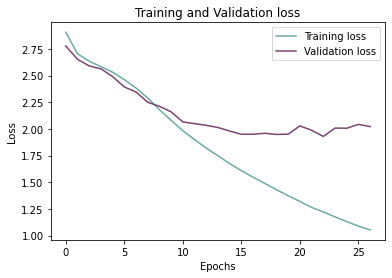

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

## Ploting traning vs validation accuracy

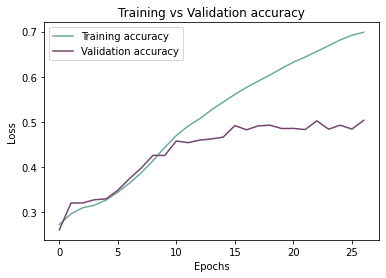

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#774571", label='Validation accuracy')
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

## Load the trained model

In [ ]:
...
# load the network weights
filename = "/content/drive/MyDrive/RNN-lstm/weights-improvement-23-1.2212.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
...
int_to_char = dict((i, c) for i, c in enumerate(chars))

## Generating text with trained LSTM model

In [ ]:
...
# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Generating fake Python code (functions, etc.):\n")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\n\nDone.")

Generating fake Python code (functions, etc.):

" e
            self.accessed = true

        super().__init__(initial, on_update)

    def __getitem_ "
_(self, app: "flask") -> str:
        return self.get_cookie_same(app)
        if self.get_cookie_samplate_coneie_semulate_context_processor(

       self. app: "flask", session: sessionmixin,         sesulng.semfaretespon(self, app: "flask", sessest: "           return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
            return self.get_cookie_same(app)
          